# Welcome to my Tutorial Notebook
# This notebook covers:
* data preparation for training on neural networks
* One hot encode all categorical features and Standardize numeric features
* Customer Churn Prediction

Losing customers is costly for any business. Identifying unhappy customers early on gives you a chance to offer them incentives to stay. This notebook describes using machine learning (ML) for the automated identification of unhappy customers, also known as customer churn prediction. ML models rarely give perfect predictions though, so this notebook is also about how to incorporate the relative costs of prediction mistakes when determining the financial outcome of using ML.

# Data
Mobile operators have historical records on which customers ultimately ended up churning and which continued using the service. We can use this historical information to construct an ML model of one mobile operator’s churn using a process called training. After training the model, we can pass the profile information of an arbitrary customer (the same profile information that we used to train the model) to the model, and have the model predict whether this customer is going to churn. Of course, we expect the model to make mistakes–after all, predicting the future is tricky business! But I’ll also show how to deal with prediction errors.

# US mobile operator. The attributes are:

* State: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ
* Account Length: the number of days that this account has been active
* Area Code: the three-digit area code of the corresponding customer’s phone number
* Phone: the remaining seven-digit phone number
* Int’l Plan: whether the customer has an international calling plan: yes/no
* VMail Plan: whether the customer has a voice mail feature: yes/no
* VMail Message: presumably the average number of voice mail messages per month
* Day Mins: the total number of calling minutes used during the day
* Day Calls: the total number of calls placed during the day
* Day Charge: the billed cost of daytime calls
* Eve Mins, Eve Calls, Eve Charge: the billed cost for calls placed during the evening
* Night Mins, Night Calls, Night Charge: the billed cost for calls placed during nighttime
* Intl Mins, Intl Calls, Intl Charge: the billed cost for international calls
* CustServ Calls: the number of calls placed to Customer Service
* Churn?: whether the customer left the service: true/false
* The last attribute, Churn?, is known as the target attribute–the attribute that we want the ML model to predict. Because the target attribute is binary, our model will be performing binary prediction, also known as binary classification.

Let's begin exploring the data:

In [1]:
#Let's import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
import re
from IPython.display import display
from time import strftime, gmtime

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, KBinsDiscretizer, LabelEncoder
# Column Transformer
from sklearn.compose import ColumnTransformer

# Data Underestanding

In [2]:
# Output columns
columns = ["Churn?", "State", "Account Length", "Area Code", "Int'l Plan",
           "VMail Plan", "VMail Message", "Day Mins", "Day Calls", 
           "Eve Mins", "Eve Calls", 
           "Night Mins", "Night Calls",
           "Intl Mins", "Intl Calls",
           "CustServ Calls"]

In [3]:
#Let's import the dataset
df = pd.read_csv('../input/customer-churn/churn.csv')
pd.set_option('display.max_columns', 30)

In [4]:
df.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [5]:
#let's check the datatypes of each feature
df.dtypes

State              object
Account Length      int64
Area Code           int64
Phone              object
Int'l Plan         object
VMail Plan         object
VMail Message       int64
Day Mins          float64
Day Calls           int64
Day Charge        float64
Eve Mins          float64
Eve Calls           int64
Eve Charge        float64
Night Mins        float64
Night Calls         int64
Night Charge      float64
Intl Mins         float64
Intl Calls          int64
Intl Charge       float64
CustServ Calls      int64
Churn?             object
dtype: object

In [6]:
#Let's find out some infomration about the datasets
df.describe()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [7]:
# Frequency tables for each categorical feature
for column in df.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=df[column], columns='% observations', normalize='columns'))

col_0,% observations
State,
AK,0.015602
AL,0.024002
AR,0.016502
AZ,0.019202
CA,0.010201
CO,0.019802
CT,0.022202
DC,0.016202
DE,0.018302


col_0,% observations
Phone,
327-1058,0.0003
327-1319,0.0003
327-3053,0.0003
327-3587,0.0003
327-3850,0.0003
...,...
422-7728,0.0003
422-8268,0.0003
422-8333,0.0003


col_0,% observations
Int'l Plan,
no,0.90309
yes,0.09691


col_0,% observations
VMail Plan,
no,0.723372
yes,0.276628


col_0,% observations
Churn?,
False.,0.855086
True.,0.144914


# We can see immediately that:

* State appears to be quite evenly distributed
* Phone takes on too many unique values to be of any practical use. It's possible parsing out the prefix could have some value, but without more context on how these are allocated, we should avoid using it.
* Only 14% of customers churned, so there is some class imabalance, but nothing extreme.
* Most of the numeric features are surprisingly nicely distributed, with many showing bell-like gaussianity. VMail Message being a notable exception (and Area Code showing up as a feature we should convert to non-numeric).

# Data Visualization

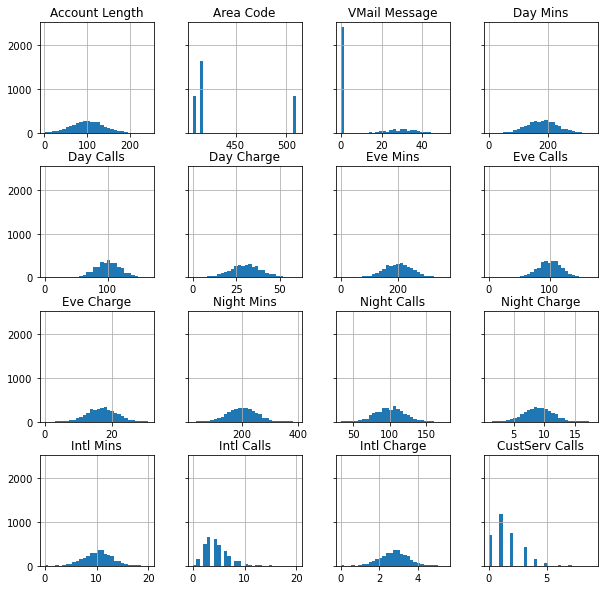

In [8]:
# Histograms for each numeric features
hist = df.hist(bins=30, sharey=True, figsize=(10, 10))

In [9]:
df.drop(columns=['Phone'], inplace=True)
df['Area Code'] = df['Area Code'].astype(object)

Next let's look at the relationship between each of the features and our target variable.

In [10]:
for column in df.select_dtypes(include=['object']).columns:
    if column != 'Churn?':
        display(pd.crosstab(index=df[column], columns=df['Churn?'], normalize='columns'))

Churn?,False.,True.
State,,
AK,0.017193,0.006211
AL,0.025263,0.016563
AR,0.015439,0.022774
AZ,0.021053,0.008282
CA,0.008772,0.018634
CO,0.020000,0.018634
CT,0.021754,0.024845
DC,0.017193,0.010352
DE,0.018246,0.018634


Churn?,False.,True.
Area Code,,
408,0.251228,0.252588
415,0.497895,0.488613
510,0.250877,0.258799


Churn?,False.,True.
Int'l Plan,,
no,0.934737,0.716356
yes,0.065263,0.283644


Churn?,False.,True.
VMail Plan,,
no,0.704561,0.834369
yes,0.295439,0.165631


* Let's Visualize the relationship of each feature with the two types (False, True) of the Target

Account Length


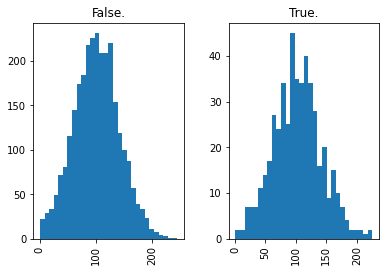

VMail Message


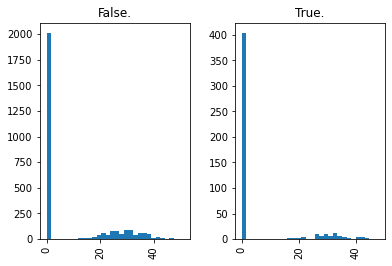

Day Mins


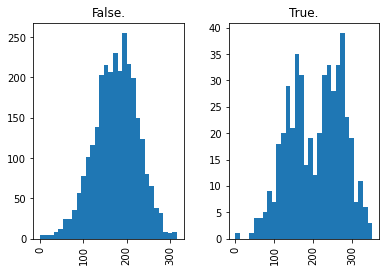

Day Calls


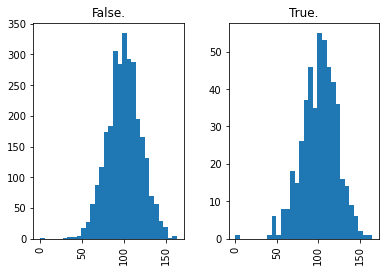

Day Charge


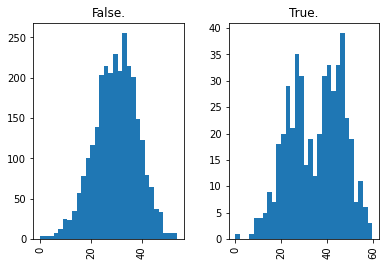

Eve Mins


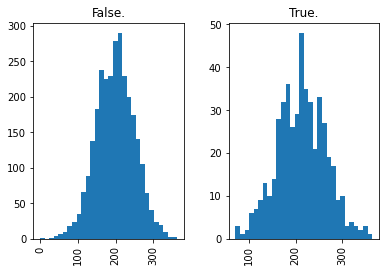

Eve Calls


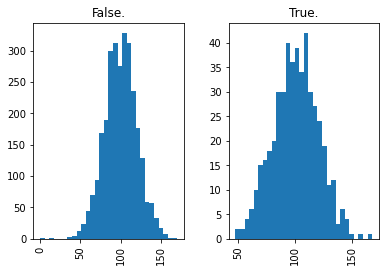

Eve Charge


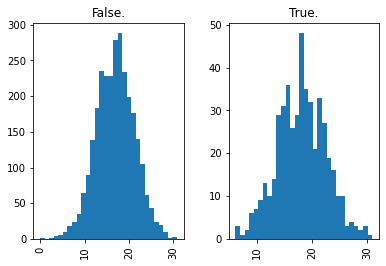

Night Mins


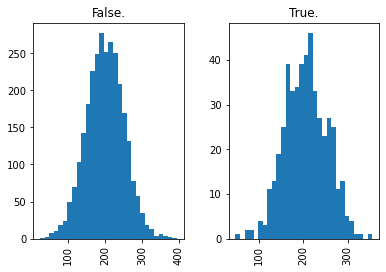

Night Calls


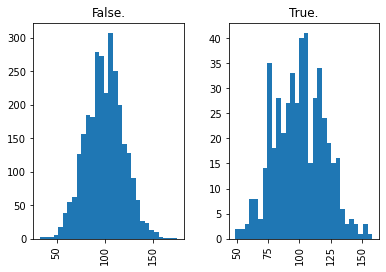

Night Charge


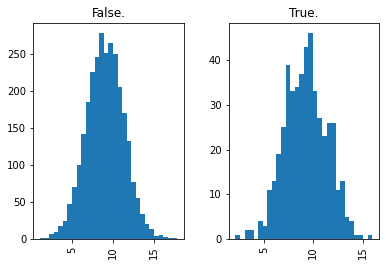

Intl Mins


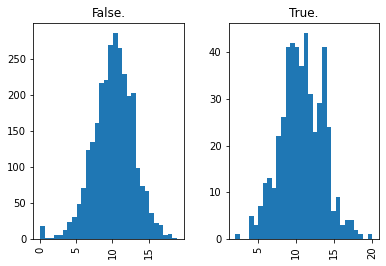

Intl Calls


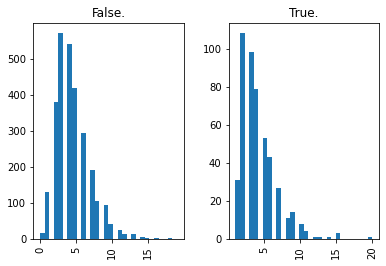

Intl Charge


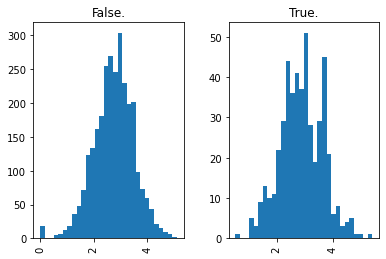

CustServ Calls


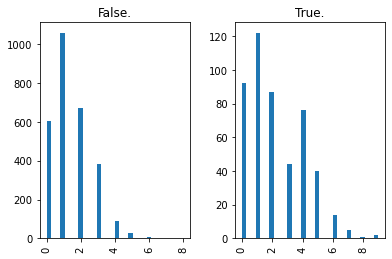

In [11]:
for column in df.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = df[[column, 'Churn?']].hist(by='Churn?', bins=30)
    plt.show()

* Let's get some inution about the correlation of each fatures

In [12]:
display(df.corr())

,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
Account Length,1.000000,-0.004628,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546,-0.003796
VMail Message,-0.004628,1.000000,0.000778,-0.009548,0.000776,0.017562,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263
Day Mins,0.006216,0.000778,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,0.008033,-0.010092,-0.013423
Day Calls,0.038470,-0.009548,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942
Day Charge,0.006214,0.000776,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427
Eve Mins,-0.006757,0.017562,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,0.002541,-0.011067,-0.012985
Eve Calls,0.019260,-0.005864,0.015769,0.006462,0.015769,-0.011430,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.017434,0.008674,0.002423
Eve Charge,-0.006745,0.017578,0.007029,-0.021449,0.007036,1.000000,-0.011423,1.000000,-0.012592,0.007596,-0.012601,-0.011043,0.002541,-0.011074,-0.012987
Night Mins,-0.008955,0.007681,0.004323,0.022938,0.004324,-0.012584,-0.002093,-0.012592,1.000000,0.011204,0.999999,-0.015207,-0.012353,-0.015180,-0.009288
Night Calls,-0.013176,0.007123,0.022972,-0.019557,0.022972,0.007586,0.007710,0.007596,0.011204,1.000000,0.011188,-0.013605,0.000305,-0.013630,-0.012802


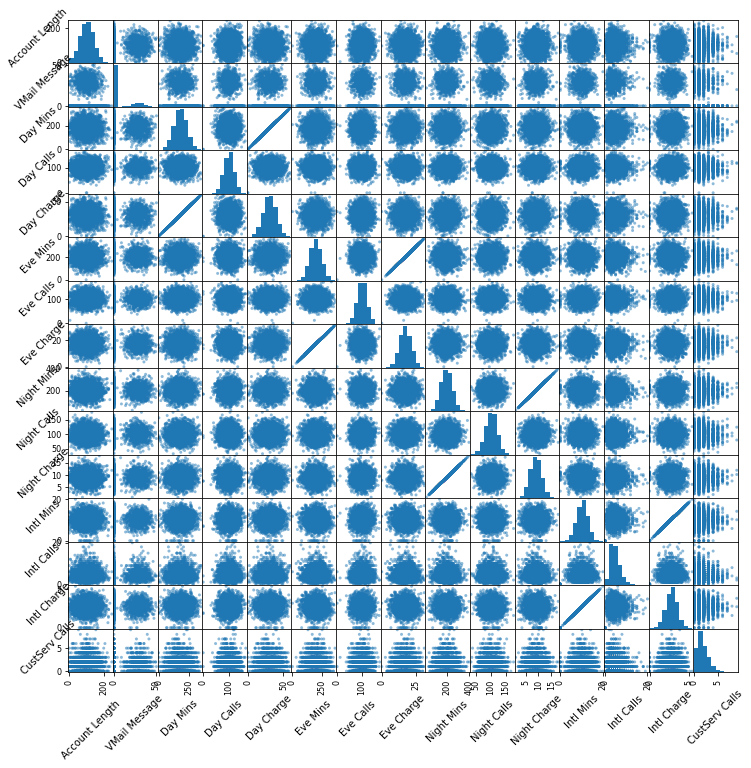

In [13]:
# https://stackoverflow.com/questions/43217174/how-can-the-sizes-and-rotations-of-text-of-a-pandas-scatter-matrix-be-set
scatter_matrix = pd.plotting.scatter_matrix(df, figsize=(12, 12))

for ax in scatter_matrix.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize = 10, rotation = 45)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 10, rotation = 45)        
    
plt.show()    

# Notice
We see several features that essentially have 100% correlation with one another. Including these feature pairs in some machine learning algorithms can create catastrophic problems, while in others it will only introduce minor redundancy and bias. Let's remove one feature from each of the highly correlated pairs: Day Charge from the pair with Day Mins, Night Charge from the pair with Night Mins, Intl Charge from the pair with Intl Mins:

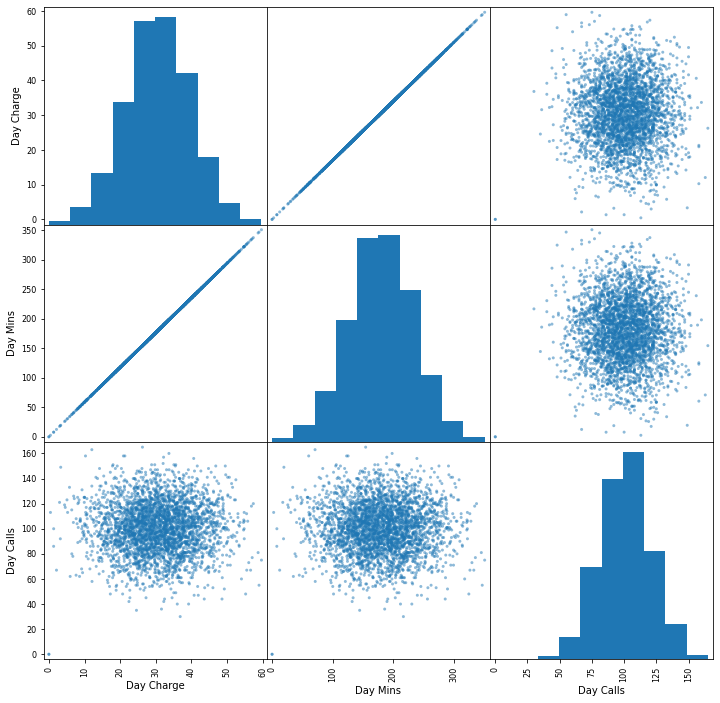

In [14]:
pd.plotting.scatter_matrix(df[['Day Charge','Day Mins','Day Calls']], figsize=(12, 12))
plt.show()

In [15]:
# Drop columns that are highly correlated with other columns
df.drop(columns=['Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge'], inplace=True)

# Missing Values

In [16]:
#missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
Churn?,0,0.0
CustServ Calls,0,0.0
Intl Calls,0,0.0
Intl Mins,0,0.0
Night Calls,0,0.0
Night Mins,0,0.0
Eve Calls,0,0.0
Eve Mins,0,0.0
Day Calls,0,0.0
Day Mins,0,0.0


* Great!, We do not have missing values

* let's convert our categorical features into numeric features.

In [17]:
#encode_features =  ["Churn?", "State", "Int'l Plan", "VMail Plan"]
# df['Churn?'].unique()

state_list = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
churn_list = ['False.', 'True.']
plans = ['no', 'yes']

# Encode Class Labels to integers
state_le = LabelEncoder()
state_le.fit(state_list)

churn_le = LabelEncoder()
churn_le.fit(churn_list)

plans_le = LabelEncoder()
plans_le.fit(plans)

LabelEncoder()

In [18]:
df.head()

,State,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,Churn?
0,KS,128,415,no,yes,25,265.1,110,197.4,99,244.7,91,10.0,3,1,False.
1,OH,107,415,no,yes,26,161.6,123,195.5,103,254.4,103,13.7,3,1,False.
2,NJ,137,415,no,no,0,243.4,114,121.2,110,162.6,104,12.2,5,0,False.
3,OH,84,408,yes,no,0,299.4,71,61.9,88,196.9,89,6.6,7,2,False.
4,OK,75,415,yes,no,0,166.7,113,148.3,122,186.9,121,10.1,3,3,False.


In [19]:
# Encode specific columns
df['State'] = state_le.transform(df['State'])
df['Churn?'] = churn_le.transform(df['Churn?'])
df["Int'l Plan"] = plans_le.transform(df["Int'l Plan"])
df["VMail Plan"] = plans_le.transform(df["VMail Plan"])

In [20]:
df.head()

,State,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,Churn?
0,16,128,415,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0
1,35,107,415,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0
2,31,137,415,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0
3,35,84,408,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0
4,36,75,415,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0


In [21]:
df.tail()

,State,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,Churn?
3328,3,192,415,0,1,36,156.2,77,215.5,126,279.1,83,9.9,6,2,0
3329,49,68,415,0,0,0,231.1,57,153.4,55,191.3,123,9.6,4,3,0
3330,39,28,510,0,0,0,180.8,109,288.8,58,191.9,91,14.1,6,2,0
3331,6,184,510,1,0,0,213.8,105,159.6,84,139.2,137,5.0,10,2,0
3332,42,74,415,0,1,25,234.4,113,265.9,82,241.4,77,13.7,4,0,0


In [22]:
df.shape

(3333, 16)

# Additional Data Transformation
* One Hot Encoding of categorical features and Standardization of numeric features
* Both these transformation are required for training on linear models and on neural network

In [23]:
# Customer churn is a binary label - no need to one hot encode
# However, for multi-class classification, label needs to be one hot encoded for neural network training.

# All other categorical features need to be 
categorical_features =['State',"Int'l Plan","VMail Plan",'Area Code']

numeric_features = ['Account Length','VMail Message',
                    'Day Mins','Day Calls','Eve Mins','Eve Calls','Night Mins','Night Calls',
                   'Intl Mins','Intl Calls','CustServ Calls']

In [24]:
categorical_features + numeric_features

['State',
 "Int'l Plan",
 'VMail Plan',
 'Area Code',
 'Account Length',
 'VMail Message',
 'Day Mins',
 'Day Calls',
 'Eve Mins',
 'Eve Calls',
 'Night Mins',
 'Night Calls',
 'Intl Mins',
 'Intl Calls',
 'CustServ Calls']

In [25]:
colTransformer = ColumnTransformer([('onehot',
                                     OneHotEncoder(categories='auto',sparse=False),
                                     categorical_features),
                                    ('standardize',
                                    StandardScaler(),numeric_features)
                                   ],
                                   remainder="passthrough")

In [26]:
colTransformer.fit(df[categorical_features + numeric_features])

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehot', OneHotEncoder(sparse=False),
                                 ['State', "Int'l Plan", 'VMail Plan',
                                  'Area Code']),
                                ('standardize', StandardScaler(),
                                 ['Account Length', 'VMail Message', 'Day Mins',
                                  'Day Calls', 'Eve Mins', 'Eve Calls',
                                  'Night Mins', 'Night Calls', 'Intl Mins',
                                  'Intl Calls', 'CustServ Calls'])])

In [27]:
train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=1729), 
                                                  [int(0.7 * len(df)), int(0.9 * len(df))])

In [28]:
print(train_data.shape,validation_data.shape,test_data.shape)

(2333, 16) (666, 16) (334, 16)


In [29]:
train_data[columns].head()

,Churn?,State,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls
1095,0,13,106,510,0,0,0,274.4,120,198.6,82,160.8,62,6.0,3,1
608,0,50,28,415,0,0,0,187.8,94,248.6,86,208.8,124,10.6,5,0
2908,1,33,148,415,0,0,0,279.3,104,201.6,87,280.8,99,7.9,2,2
943,0,37,132,510,0,0,0,191.9,107,206.9,127,272.0,88,12.6,2,1
693,0,31,92,510,0,1,29,155.4,110,188.5,104,254.9,118,8.0,4,3


In [30]:
train_data_transformed = colTransformer.transform (train_data[categorical_features + numeric_features])

validation_data_transformed = colTransformer.transform (validation_data[categorical_features + numeric_features])

test_data_transformed = colTransformer.transform (test_data[categorical_features + numeric_features])

In [31]:
print(train_data_transformed.shape, validation_data_transformed.shape, test_data_transformed.shape)

(2333, 69) (666, 69) (334, 69)


In [32]:
train_data['Churn?'].values

array([0, 0, 1, ..., 0, 0, 0])

# Need to concatenate Label to the data
https://docs.scipy.org/doc/numpy/reference/generated/numpy.concatenate.html
* a = np.array([[1, 2], [3, 4]])
* b = np.array([[5, 6]])
* np.concatenate((b.T,a), axis=1)

In [33]:
train_data_transformed = np.concatenate((np.array([train_data['Churn?']]).T, train_data_transformed),axis=1)
validation_data_transformed = np.concatenate((np.array([validation_data['Churn?']]).T, validation_data_transformed),axis=1)
test_data_transformed = np.concatenate((np.array([test_data['Churn?']]).T, test_data_transformed),axis=1)

In [34]:
print(train_data_transformed.shape, validation_data_transformed.shape, test_data_transformed.shape)

(2333, 70) (666, 70) (334, 70)


In [35]:
train_data_transformed[:1]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.1239496 ,
        -0.59175986,  1.73753694,  0.97499676, -0.04694389, -0.90936958,
        -0.79246592, -1.94768203, -1.5179703 , -0.6

In [36]:
# https://stackoverflow.com/questions/6081008/dump-a-numpy-array-into-a-csv-file
# Write Training Set
np.savetxt('train_onehot.csv',train_data_transformed,delimiter=",",fmt='%.5e')

In [37]:
# Write Validation Set
np.savetxt('validation_onehot.csv',validation_data_transformed,delimiter=",",fmt='%.5e')

In [38]:
# Write Test Set
np.savetxt('test_onehot.csv',test_data_transformed,delimiter=",",fmt='%.5e')

# Store Original Format
# Easy to assess performance

In [39]:
# Write Training Set
train_data.to_csv('train.csv'
                          ,index=False,header=False
                          ,columns=columns)

In [40]:
# Write Validation Set
validation_data.to_csv('validation.csv'
                          ,index=False,header=False
                          ,columns=columns)

In [41]:
# Write Test Set
test_data.to_csv('test.csv'
                          ,index=False,header=False
                          ,columns=columns)

In [42]:
# Write Column List
with open('column_list.txt','w') as f:
    f.write(','.join(columns))

# Binary Classification using TensorFlow 
Build the Neural Network using Keras - Easy and Portable across different implementations
https://keras.io/


In [43]:
# https://keras.io/
# https://github.com/keras-team/keras/issues/2743
# Change Kernel to use Tensor Flow. For example: conda_tensorflow_p36
import sys
import numpy as np
# Set random seed
np.random.seed(0)

import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn.metrics import classification_report, confusion_matrix

# Column Transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, KBinsDiscretizer

# Keras Library
from keras.models import Sequential
from keras.layers import Dense, Activation

In [44]:
ls

__notebook__.ipynb  test.csv         train.csv         validation.csv
column_list.txt     test_onehot.csv  train_onehot.csv  validation_onehot.csv


In [45]:
train_file = 'train_onehot.csv'
validation_file = 'validation_onehot.csv'
test_file = 'test_onehot.csv'

In [46]:
# Specify the column names as the file does not have column header
df_train = pd.read_csv(train_file, header=None)
df_validation = pd.read_csv(validation_file, header=None)
df_test = pd.read_csv(test_file, header=None)

In [47]:
df_train.shape

(2333, 70)

In [48]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.123950,-0.59176,1.737540,0.974997,-0.046944,-0.909370,-0.792466,-1.947680,-1.517970,-0.601195,-0.427932
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,-1.835060,-0.59176,0.147356,-0.320723,0.939128,-0.708563,0.156784,1.221130,0.129936,0.211534,-1.188220
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.178800,-0.59176,1.827510,0.177631,0.012220,-0.658361,1.580660,-0.056615,-0.837313,-1.007560,0.332354
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.776951,-0.59176,0.222642,0.327137,0.116744,1.349710,1.406630,-0.618824,0.846417,-1.007560,-0.427932
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,-0.227667,1.52715,-0.447584,0.476643,-0.246130,0.195068,1.068460,0.914473,-0.801489,-0.194831,1.092640


In [49]:
df_validation.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,-1.357860,1.45408,-0.706494,-0.320723,-0.650420,0.395875,-1.727870,-0.823264,-0.873137,-1.007560,-0.427932
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,-1.784820,-0.59176,1.241750,0.327137,-0.494621,-1.210580,1.711180,-0.516604,0.380704,-1.007560,-1.188220
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.123950,1.74634,-0.254780,1.274010,0.306070,-0.357151,-0.549221,-0.721044,1.383780,1.430630,1.852930
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.751836,-0.59176,1.122400,0.376972,-0.662253,-0.457554,2.399390,0.454484,1.598720,1.430630,1.092640
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,-0.453706,2.11167,-1.859650,0.426808,0.187741,0.044463,-0.418699,0.096715,0.559825,-0.194831,-0.427932


In [50]:
df_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.133190,-0.591760,-0.770762,-0.171217,-0.261908,0.897892,-1.077240,-0.772154,-0.550721,0.617898,-0.427932
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.776951,1.234880,-1.222480,-0.221052,1.359190,0.345673,0.558237,-0.669934,-1.123910,1.024260,0.332354
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.274642,0.650357,0.062889,-0.270887,1.021960,1.249300,-0.873548,-0.261055,-0.192480,-0.601195,-1.188220
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,-0.252782,1.161820,-1.584210,0.576314,-0.346710,1.399910,0.787639,1.681120,-0.120832,-0.601195,-1.188220
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,-1.985750,-0.591760,-1.275730,0.327137,-0.680002,-0.357151,0.028239,-0.209945,-0.264128,0.211534,-1.188220


In [51]:
X_train = df_train.iloc[:,1:] # Features: 1st column onwards 
y_train = df_train.iloc[:,0].ravel() # Target: 0th column

X_validation = df_validation.iloc[:,1:] # Features: 1st column onwards 
y_validation = df_validation.iloc[:,0].ravel() # Target: 0th column

X_test = df_test.iloc[:,1:] # Features: 1st column onwards 
y_test = df_test.iloc[:,0].ravel() # Target: 0th column

# Build Model using Keras
Reference: https://keras.io/getting-started/sequential-model-guide/

In [52]:
# https://keras.io/getting-started/sequential-model-guide/
model = Sequential()
# 1 hidden layer with 30 neurons with relu activation
# output layer - binaryclassification, so use sigmoid activation
# optimizer - use adam or rmsprop
# loss function - logistic loss function - called as binary cross entropy in keras
# metrics - additional metrics to report
model.add(Dense(30, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

* We could use the Early Stopping Techniques to avoid from overfitting

In [53]:
from keras.callbacks import EarlyStopping

In [54]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [55]:
# Train the model, iterating on the data in batches of 32 samples
history = model.fit(X_train, y_train, epochs=20, batch_size=32,
         validation_data=(X_validation,y_validation),callbacks=[early_stopping])

Epoch 1/20
73/73 [==============================] - 0s 4ms/step - loss: 0.5003 - accuracy: 0.8260 - val_loss: 0.4447 - val_accuracy: 0.8348
Epoch 2/20
73/73 [==============================] - 0s 1ms/step - loss: 0.3815 - accuracy: 0.8611 - val_loss: 0.3944 - val_accuracy: 0.8378
Epoch 3/20
73/73 [==============================] - 0s 1ms/step - loss: 0.3403 - accuracy: 0.8637 - val_loss: 0.3655 - val_accuracy: 0.8423
Epoch 4/20
73/73 [==============================] - 0s 1ms/step - loss: 0.3144 - accuracy: 0.8710 - val_loss: 0.3504 - val_accuracy: 0.8514
Epoch 5/20
73/73 [==============================] - 0s 1ms/step - loss: 0.2971 - accuracy: 0.8736 - val_loss: 0.3422 - val_accuracy: 0.8634
Epoch 6/20
73/73 [==============================] - 0s 1ms/step - loss: 0.2824 - accuracy: 0.8808 - val_loss: 0.3419 - val_accuracy: 0.8604
Epoch 7/20
73/73 [==============================] - 0s 1ms/step - loss: 0.2708 - accuracy: 0.8834 - val_loss: 0.3343 - val_accuracy: 0.8664
Epoch 8/20
73/73 [==

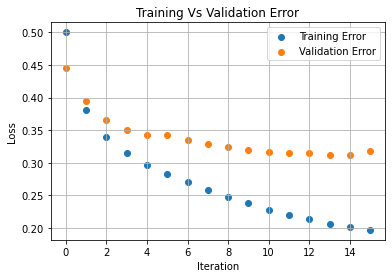

In [56]:
plt.scatter(x=history.epoch,y=history.history['loss'],label='Training Error')
plt.scatter(x=history.epoch,y=history.history['val_loss'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

The continuous valued predictions coming from our model tend to skew toward 0 or 1, but there is sufficient mass between 0.1 and 0.9 that adjusting the cutoff should indeed shift a number of customers' predictions. For example...

In [57]:
# Predicts a binary outcome for each observation
result = model.predict(X_test)

In [58]:
result[:10]

array([[0.01329264],
       [0.02998218],
       [0.01486579],
       [0.07697019],
       [0.0102345 ],
       [0.01291355],
       [0.8042109 ],
       [0.02845937],
       [0.7186857 ],
       [0.01240975]], dtype=float32)

In [59]:
column_list_file = 'column_list.txt'
test_file = 'test.csv'

In [60]:
columns = ''
with open(column_list_file,'r') as f:
    columns = f.read().split(',')

In [61]:
df_test = pd.read_csv(test_file,names=columns)

In [62]:
df_test['predicted_prob'] = result

In [63]:
df_test['predicted_class'] = np.where(result > 0.5,1,0)

In [64]:
df_test[['Churn?','predicted_class', 'predicted_prob']].head(10)

,Churn?,predicted_class,predicted_prob
0,0,0,0.013293
1,0,0,0.029982
2,0,0,0.014866
3,0,0,0.076970
4,0,0,0.010235
5,0,0,0.012914
6,1,1,0.804211
7,0,0,0.028459
8,0,1,0.718686
9,0,0,0.012410


# Binary Classifier Metrics

In [65]:
# Reference: https://scikit-learn.org/stable/modules/model_evaluation.html
# Explicitly stating labels. Pass=1, Fail=0
def true_positive(y_true, y_pred): 
    return confusion_matrix(y_true, y_pred,labels=[1,0])[0, 0]

def true_negative(y_true, y_pred): 
    return confusion_matrix(y_true,y_pred,labels=[1,0])[1, 1]

def false_positive(y_true, y_pred): 
    return confusion_matrix(y_true, y_pred,labels=[1,0])[1, 0]

def false_negative(y_true, y_pred): 
    return confusion_matrix(y_true, y_pred,labels=[1,0])[0, 1]

In [66]:
# Compute Binary Classifier Metrics
# Returns a dictionary {"MetricName":Value,...}

def binary_classifier_metrics(y_true, y_pred):
    metrics = {}

    # References: 
    #  https://docs.aws.amazon.com/machine-learning/latest/dg/binary-classification.html
    #  https://en.wikipedia.org/wiki/Confusion_matrix
    
    # Definition:
    # true positive = tp = how many samples were correctly classified as positive (count)
    # true negative = tn = how many samples were correctly classified as negative (count)
    # false positive = fp = how many negative samples were mis-classified as positive (count)
    # false_negative = fn = how many positive samples were mis-classified as negative (count)
    
    # positive = number of positive samples (count)
    #          = true positive + false negative
    # negative = number of negative samples (count)
    #          = true negative + false positive
    
    tp = true_positive(y_true, y_pred)
    tn = true_negative(y_true, y_pred)
    fp = false_positive(y_true, y_pred)
    fn = false_negative(y_true, y_pred)
    
    positive = tp + fn
    negative = tn + fp
    
    metrics['TruePositive'] = tp
    metrics['TrueNegative'] = tn
    metrics['FalsePositive'] = fp
    metrics['FalseNegative'] = fn
    
    metrics['Positive'] = positive
    metrics['Negative'] = negative
    
    # True Positive Rate (TPR, Recall) = true positive/positive
    # How many positives were correctly classified? (fraction)
    # Recall value closer to 1 is better. closer to 0 is worse
    if tp == 0:
        recall = 0
    else:
        recall = tp/positive
        
    metrics['Recall'] = recall
    
    # True Negative Rate = True Negative/negative
    # How many negatives were correctly classified? (fraction)
    # True Negative Rate value closer to 1 is better. closer to 0 is worse
    if tn == 0:
        tnr = 0
    else:
        tnr = tn/(negative)
    metrics['TrueNegativeRate'] = tnr
    
    # Precision = True Positive/(True Positive + False Positive)
    # How many positives classified by the algorithm are really positives? (fraction)
    # Precision value closer to 1 is better. closer to 0 is worse
    if tp == 0:
        precision = 0
    else:
        precision = tp/(tp + fp)
    metrics['Precision'] = precision
    
    # Accuracy = (True Positive + True Negative)/(total positive + total negative)
    # How many positives and negatives were correctly classified? (fraction)
    # Accuracy value closer to 1 is better. closer to 0 is worse
    accuracy = (tp + tn)/(positive + negative)
    metrics['Accuracy'] = accuracy
    
    # False Positive Rate (FPR, False Alarm) = False Positive/(total negative)
    # How many negatives were mis-classified as positives (fraction)
    # False Positive Rate value closer to 0 is better. closer to 1 is worse
    if fp == 0:
        fpr = 0
    else:
        fpr = fp/(negative)
    metrics['FalsePositiveRate'] = fpr
    
    # False Negative Rate (FNR, Misses) = False Negative/(total Positive)
    # How many positives were mis-classified as negative (fraction)
    # False Negative Rate value closer to 0 is better. closer to 1 is worse
    fnr = fn/(positive)
    metrics['FalseNegativeRate'] = fnr
    
    # F1 Score = harmonic mean of Precision and Recall
    # F1 Score closer to 1 is better. Closer to 0 is worse.
    if precision == 0 or recall == 0:
        f1 = 0
    else:        
        f1 = 2*precision*recall/(precision+recall)

    metrics['F1'] = f1
    
    return metrics

In [67]:
# Reference: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [68]:
# Compute confusion matrix
# 1 = customer left/churn, 0 = stayed
cnf_matrix = confusion_matrix(df_test['Churn?'], df_test['predicted_class'],labels=[1,0])

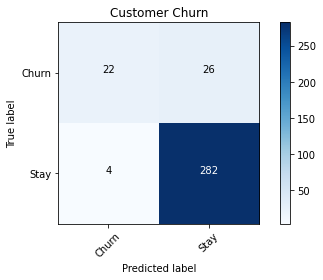

In [69]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=['Churn','Stay'],
                      title='Customer Churn')

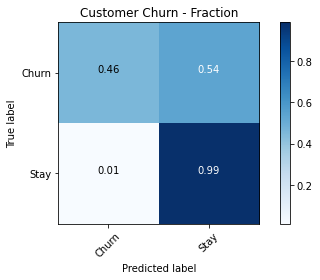

In [70]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Churn','Stay'],
                      title='Customer Churn - Fraction', normalize=True)

In [71]:
metrics = [binary_classifier_metrics(df_test['Churn?'], df_test['predicted_class'])]
df_metrics=pd.DataFrame.from_dict(metrics)
df_metrics.index = ['Model']

In [72]:
df_metrics

,TruePositive,TrueNegative,FalsePositive,FalseNegative,Positive,Negative,Recall,TrueNegativeRate,Precision,Accuracy,FalsePositiveRate,FalseNegativeRate,F1
Model,22,282,4,26,48,286,0.458333,0.986014,0.846154,0.91018,0.013986,0.541667,0.594595


In [73]:
print('Counts')
print(df_metrics[['TruePositive',
                  'FalseNegative',
                  'FalsePositive',
                  'TrueNegative',]].round(2))
print()
print('Fractions')
print(df_metrics[['Recall',
                  'FalseNegativeRate',
                  'FalsePositiveRate',
                  'TrueNegativeRate',]].round(2))
print()

print(df_metrics[['Precision',
                  'Accuracy',
                  'F1']].round(2))

Counts
       TruePositive  FalseNegative  FalsePositive  TrueNegative
Model            22             26              4           282

Fractions
       Recall  FalseNegativeRate  FalsePositiveRate  TrueNegativeRate
Model    0.46               0.54               0.01              0.99

       Precision  Accuracy    F1
Model       0.85      0.91  0.59


In [74]:
print(classification_report(df_test['Churn?'], df_test['predicted_class'],
                            labels=[1,0],
                            target_names=['Churn','Stay']))

              precision    recall  f1-score   support

       Churn       0.85      0.46      0.59        48
        Stay       0.92      0.99      0.95       286

    accuracy                           0.91       334
   macro avg       0.88      0.72      0.77       334
weighted avg       0.91      0.91      0.90       334



In [75]:
df = df_test.sort_values('Churn?')
df = df.reset_index(drop=True)

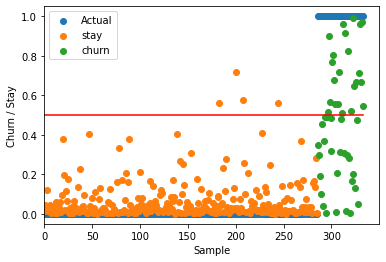

In [76]:
stay = df[df['Churn?']==0]
churn = df[df['Churn?']==1]

plt.figure()
plt.scatter(df.index,df['Churn?'],label='Actual')
plt.scatter(stay.index,stay['predicted_prob'],label='stay')
plt.scatter(churn.index,churn['predicted_prob'],label='churn')
plt.plot([df_test.index.min(),df_test.index.max()],[0.5,0.5],color='r')
plt.xlim(left=0)
plt.xlabel('Sample')
plt.ylabel('Churn / Stay')
plt.legend(loc=2)
plt.show()

* Left side of plot has all "stay" samples - Majority of the samples are clustered near 0 (good) and only few are misclassified (above 0.5 threshold)
* Right side of plot has all "churn" samples - Majority of the samples are above cutoff (good); however, few are misclassified (below 0.5 threshold)

In [77]:
# ROC AUC Score - Measure of how Recall and False Alarm change at different cutoff thresholds
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(df_test['Churn?'], df_test['predicted_prob'])
print('ROC AUC Score: {0:.3f}'.format(roc_score))

ROC AUC Score: 0.895


In [78]:
pd.crosstab(index=df_test['Churn?'], columns=np.where(df_test['predicted_prob'] > 0.5, 1, 0))

col_0,0,1
Churn?,,
0,282,4
1,26,22


We can see that changing the cutoff from 0.5 to 0.3 results in 1 more true positives, 3 more false positives, and 1 fewer false negatives. The numbers are small overall here, but that's 6-10% of customers overall that are shifting because of a change to the cutoff. Was this the right decision? We may end up retaining 3 extra customers, but we also unnecessarily incentivized 5 more customers who would have stayed. Determining optimal cutoffs is a key step in properly applying machine learning in a real-world setting. Let's discuss this more broadly and then apply a specific, hypothetical solution for our current problem.

Relative cost of errors
Any practical binary classification problem is likely to produce a similarly sensitive cutoff. That by itself isn’t a problem. After all, if the scores for two classes are really easy to separate, the problem probably isn’t very hard to begin with and might even be solvable with simple rules instead of ML.

More important, if I put an ML model into production, there are costs associated with the model erroneously assigning false positives and false negatives. I also need to look at similar costs associated with correct predictions of true positives and true negatives. Because the choice of the cutoff affects all four of these statistics, I need to consider the relative costs to the business for each of these four outcomes for each prediction.

Assigning costs
What are the costs for our problem of mobile operator churn? The costs, of course, depend on the specific actions that the business takes. Let's make some assumptions here.

First, assign the true negatives the cost of $0. Our model essentially correctly identified a happy customer in this case, and we don’t need to do anything.

False negatives are the most problematic, because they incorrectly predict that a churning customer will stay. We lose the customer and will have to pay all the costs of acquiring a replacement customer, including foregone revenue, advertising costs, administrative costs, point of sale costs, and likely a phone hardware subsidy. A quick search on the Internet reveals that such costs typically run in the hundreds of dollars so, for the purposes of this example, let's assume $500. This is the cost of false negatives.

Finally, for customers that our model identifies as churning, let's assume a retention incentive in the amount of $100.

If my provider offered me such a concession, I’d certainly think twice before leaving. This is the cost of both true positive and false positive outcomes.

In the case of false positives (the customer is happy, but the model mistakenly predicted churn), we will waste the $100 concession. We probably could have spent that $100 more effectively, but it's possible we increased the loyalty of an already loyal customer, so that’s not so bad.

* Finding the optimal cutoff

It’s clear that false negatives are substantially more costly than false positives. Instead of optimizing for error based on the number of customers, we should be minimizing a cost function that looks like this:

$500 * FN(C) + $0 * TN(C) + $100 * FP(C) + $100 * TP(C)

FN(C) means that the false negative percentage is a function of the cutoff, C, and similar for TN, FP, and TP. We need to find the cutoff, C, where the result of the expression is smallest.

A straightforward way to do this, is to simply run a simulation over a large number of possible cutoffs. We test 100 possible values in the for loop below.

In [79]:
cutoffs = np.arange(0.1, .9, 0.01)
costs = []
for c in cutoffs:
    costs.append(np.sum(np.sum(np.array([[0, 100], [500, 100]]) * 
                               pd.crosstab(index=df_test['Churn?'],columns=np.where(df_test['predicted_prob'] > c, 1, 0)))))

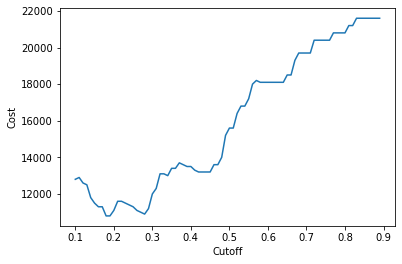

Cost is minimized near a cutoff of: 0.17999999999999997 for a cost of: 10800


In [80]:
costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.ylabel('Cost')
plt.xlabel('Cutoff')
plt.show()

print('Cost is minimized near a cutoff of:', cutoffs[np.argmin(costs)], 'for a cost of:', np.min(costs))

The above chart shows how picking a threshold too low results in costs skyrocketing as all customers are given a retention incentive. Meanwhile, setting the threshold too high results in too many lost customers, which ultimately grows to be nearly as costly. The overall cost can be minimized at $8400 by setting the cutoff to 0.46, which is substantially better than the $20k+ I would expect to lose by not taking any action.

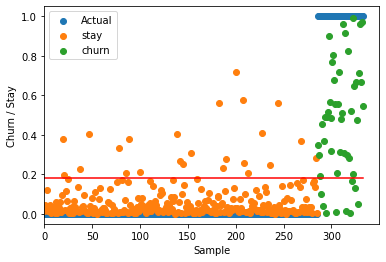

In [81]:
stay = df[df['Churn?']==0]
churn = df[df['Churn?']==1]

plt.figure()
plt.scatter(df.index,df['Churn?'],label='Actual')
plt.scatter(stay.index,stay['predicted_prob'],label='stay')
plt.scatter(churn.index,churn['predicted_prob'],label='churn')
plt.plot([df_test.index.min(),df_test.index.max()],[cutoffs[np.argmin(costs)],cutoffs[np.argmin(costs)]],color='r')
plt.xlim(left=0)
plt.xlabel('Sample')
plt.ylabel('Churn / Stay')
plt.legend(loc=2)
plt.show()

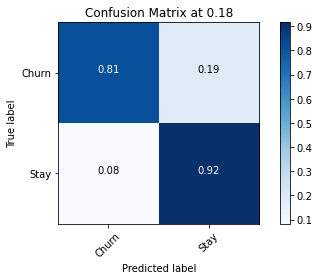

In [82]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(df['Churn?'], np.where(df['predicted_prob'] > cutoffs[np.argmin(costs)], 1, 0),labels=[1,0])

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Churn','Stay'],
                      title='Confusion Matrix at {0:0.2f}'.format(cutoffs[np.argmin(costs)]), normalize=True)


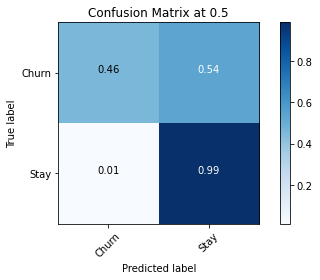

In [83]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(df['Churn?'], np.where(df['predicted_prob'] > .5, 1, 0),labels=[1,0])

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Churn','Stay'],
                      title='Confusion Matrix at 0.5', normalize=True)

In [84]:
# Improved recall and f1-score with lower cutoff
# However, precision has gone down
# So, cutoff threshold is a tradeoff based on problem at hand
print(classification_report(df['Churn?'], np.where(df['predicted_prob'] > cutoffs[np.argmin(costs)], 1, 0),
                            labels=[1,0],
                            target_names=['Churn','Stay']))

              precision    recall  f1-score   support

       Churn       0.62      0.81      0.70        48
        Stay       0.97      0.92      0.94       286

    accuracy                           0.90       334
   macro avg       0.79      0.86      0.82       334
weighted avg       0.92      0.90      0.91       334



In [85]:
print(classification_report(df['Churn?'], np.where(df['predicted_prob'] > 0.5, 1, 0),
                            labels=[1,0],
                            target_names=['Churn','Stay']))

              precision    recall  f1-score   support

       Churn       0.85      0.46      0.59        48
        Stay       0.92      0.99      0.95       286

    accuracy                           0.91       334
   macro avg       0.88      0.72      0.77       334
weighted avg       0.91      0.91      0.90       334

